In [2]:
import torch, time
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

X = mnist.data[mnist.targets < 5].float() / 255.0
y = mnist.targets[mnist.targets < 5]


In [5]:
X = X.view(X.shape[0], -1)  

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

In [8]:
class FCNN(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [9]:
def train_model(model, optimizer, X, y, criterion, batch_size):
    prev_loss = float("inf")
    losses = []
    epoch = 0
    max_epochs = 2000   # SAFETY CAP

    while epoch < max_epochs:
        model.train()
        permutation = torch.randperm(X.size(0), device="cpu").to(device)
        total_loss = 0.0

        for i in range(0, X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x = X[indices]
            batch_y = y[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (X.size(0) / batch_size)
        losses.append(avg_loss)

        # original stopping rule
        if abs(prev_loss - avg_loss) < 1e-4:
            break

        prev_loss = avg_loss
        epoch += 1

    return losses, epoch


In [10]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1)
    return accuracy_score(y.cpu(), predictions.cpu())

In [11]:
architectures = {
    "3_hidden": [784, 256, 128, 64, 5],
    "4_hidden": [784, 256, 128, 64, 32, 5],
    "5_hidden": [784, 256, 128, 64, 32, 16, 5]
}

In [12]:
def get_optimizer(name, model):
    if name == "SGD":
        return optim.SGD(model.parameters(), lr=0.001)
    if name == "Batch_GD":
        return optim.SGD(model.parameters(), lr=0.001)
    if name == "Momentum":
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    if name == "NAG":
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
    if name == "RMSProp":
        return optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-8)
    if name == "Adam":
        return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizers = ["SGD", "Batch_GD", "Momentum", "NAG", "RMSProp", "Adam"]

results = {}

for arch_name, layers in architectures.items():
    print(f"\nArchitecture: {arch_name}")
    results[arch_name] = {}

    base_model = FCNN(layers).to(device)
    base_state = base_model.state_dict()

    for opt_name in optimizers:
        model = FCNN(layers).to(device)
        model.load_state_dict(base_state)

        optimizer = get_optimizer(opt_name, model)

        batch_size = 64 if opt_name != "Batch_GD" else X_train.size(0)

        start = time.time()
        losses, epochs = train_model(
            model, optimizer, X_train, y_train, criterion, batch_size
        )
        end = time.time()

        training_time = end - start
        train_acc = evaluate(model, X_train, y_train)
        val_acc = evaluate(model, X_val, y_val)

        results[arch_name][opt_name] = {
            "epochs": epochs,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "losses": losses,
            "time": training_time,
        }

        print(f"{opt_name}: epochs={epochs}, val_acc={val_acc:.4f}, time={training_time:.2f}s")


Architecture: 3_hidden
SGD: epochs=83, val_acc=0.9663, time=49.88s
Batch_GD: epochs=1, val_acc=0.1908, time=0.13s
Momentum: epochs=93, val_acc=0.9882, time=62.72s
NAG: epochs=90, val_acc=0.9881, time=58.70s
RMSProp: epochs=16, val_acc=0.9874, time=11.64s
Adam: epochs=20, val_acc=0.9940, time=15.98s

Architecture: 4_hidden
SGD: epochs=180, val_acc=0.9753, time=125.97s
Batch_GD: epochs=1, val_acc=0.1908, time=0.12s
Momentum: epochs=76, val_acc=0.9868, time=58.37s
NAG: epochs=72, val_acc=0.9869, time=54.14s
RMSProp: epochs=8, val_acc=0.9887, time=7.41s
Adam: epochs=19, val_acc=0.9902, time=18.82s

Architecture: 5_hidden
SGD: epochs=219, val_acc=0.9771, time=174.23s
Batch_GD: epochs=1, val_acc=0.2003, time=0.09s
Momentum: epochs=37, val_acc=0.9809, time=34.84s
NAG: epochs=55, val_acc=0.9822, time=49.22s
RMSProp: epochs=11, val_acc=0.9910, time=10.55s
Adam: epochs=15, val_acc=0.9855, time=14.92s


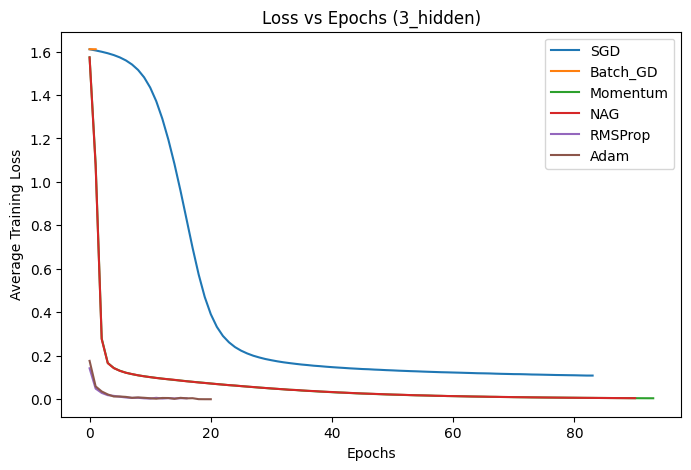

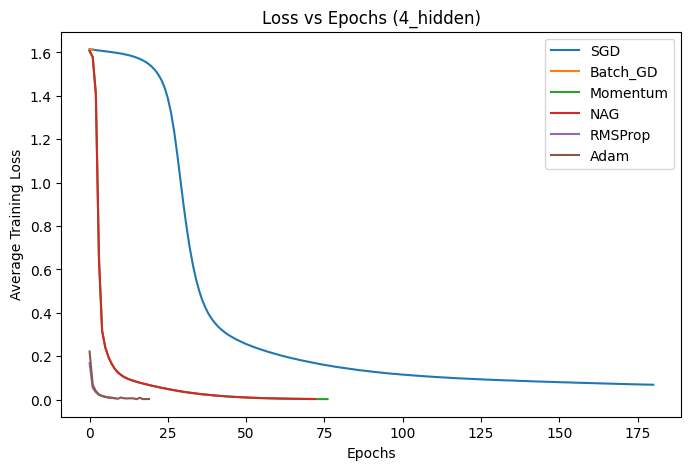

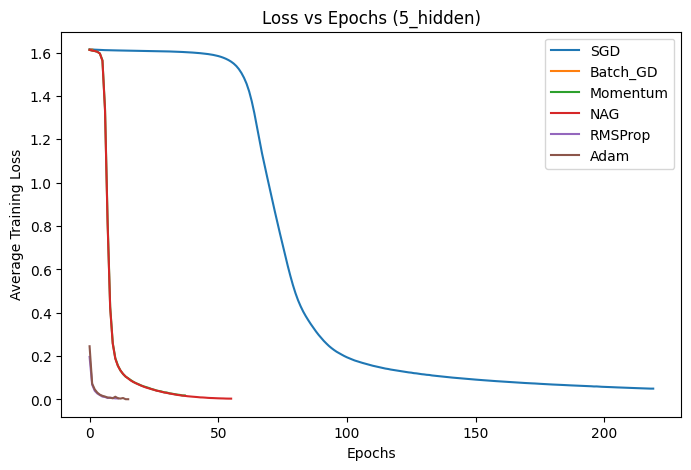

In [14]:
for arch_name in results:
    plt.figure(figsize=(8, 5))
    for opt in results[arch_name]:
        plt.plot(results[arch_name][opt]["losses"], label=opt)
    plt.title(f"Loss vs Epochs ({arch_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Average Training Loss")
    plt.legend()
    plt.show()
